#LAB

In [47]:
# Library dasar
import os
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile

# TensorFlow dan Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Evaluasi
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


#IMPORT DATASET

In [48]:

zip_path = '/content/daisynew.zip'
output_path = '/content/skindesease'

# Ekstrak file ZIP
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_path)

print(f"Ekstraksi selesai ke folder: {output_path}")

Ekstraksi selesai ke folder: /content/skindesease


#AUGMENTASI

In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir  = '/content/skindesease'

def train_val_generators(TRAINING_DIR):
  train_datagen = ImageDataGenerator(rescale=1./255,
                                      horizontal_flip=False,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      validation_split = 0.2,
                                      fill_mode='nearest')

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      class_mode="categorical",
                                                      color_mode ="rgb",
                                                      batch_size=32,
                                                      subset = "training",
                                                       shuffle = True,
                                                      target_size=(160,160))


  # validation_datagen = ImageDataGenerator(rescale=1./255)
  validation_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                                class_mode="categorical",
                                                                color_mode ="rgb",
                                                                batch_size=32,
                                                                subset = "validation",
                                                                shuffle = False,
                                                                target_size=(160,160))

  return train_generator, validation_generator


train_generator, validation_generator = train_val_generators(train_dir)
train_generator.class_indices




Found 774 images belonging to 7 classes.
Found 192 images belonging to 7 classes.


{'Biduran': 0,
 'Bisul': 1,
 'Cacar Air': 2,
 'Jerawat': 3,
 'Kurap': 4,
 'Normal': 5,
 'Panu': 6}

#PREVIEW

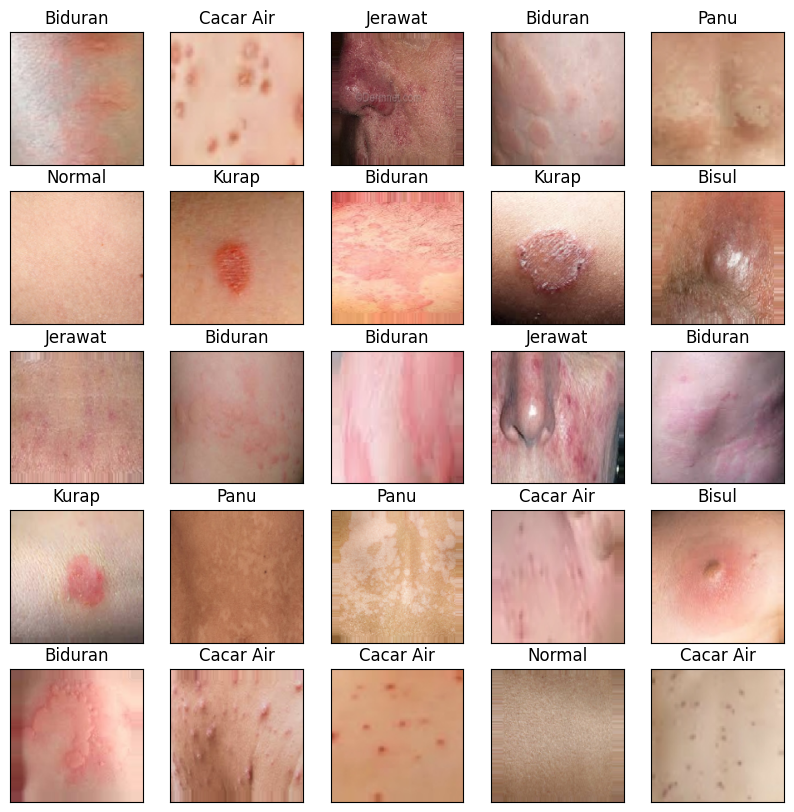

In [50]:
images, labels = next(train_generator)
class_name = ['Biduran', 'Bisul', 'Cacar Air', 'Jerawat', 'Kurap', 'Normal', 'Panu']

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(class_name[np.argmax(labels[i])])  # Tampilan label sesuai class_name
    plt.imshow(image)
plt.show()


#BUILD MODEL

In [51]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.models import Model

#  InceptionV3
pretrained_model = InceptionV3(include_top=False, weights="imagenet", input_shape=(160, 160, 3))

# Menambahkan lapisan tambahan di atas pretrained model
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling untuk meratakan output
x = BatchNormalization()(x)  # Normalisasi batch
x = Dropout(rate=0.5)(x)  # Dropout untuk menghindari overfitting
x = Dense(1024, activation='relu')(x)  # Fully connected layer dengan 1024 neuron
x = Dropout(rate=0.7)(x)  # Dropout lain untuk menghindari overfitting

# Output laye
pred = Dense(7, activation='softmax')(x)

# Bentuk model akhir
model = Model(inputs=pretrained_model.input, outputs=pred)

# Membekukan lapisan pretrained agar tidak di-train ulang
for layer in pretrained_model.layers:
    layer.trainable = False

#  ringkasan model
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_282 (Conv2D)       │ (None, 79, 79, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_285   │ (None, 79, 79, 32)     │             96 │ conv2d_282[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_282            │ (None, 79, 79, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_283 (Conv2D)       │ (None, 77, 77, 32)     │          9,216 │ activation_282[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_286   │ (None, 77, 77, 32)     │             96 │ conv2d_283[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_283            │ (None, 77, 77, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_284 (Conv2D)       │ (None, 77, 77, 64)     │         18,432 │ activation_283[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_287   │ (None, 77, 77, 64)     │            192 │ conv2d_284[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_284            │ (None, 77, 77, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 38, 38, 64)     │              0 │ activation_284[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_285 (Conv2D)       │ (None, 38, 38, 80)     │          5,120 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_288   │ (None, 38, 38, 80)     │            240 │ conv2d_285[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_285            │ (None, 38, 38, 80)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_286 (Conv2D)  

 Total params: 23,916,327 (91.23 MB)

 Trainable params: 2,109,447 (8.05 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

In [53]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

In [54]:
model.compile(Adam(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

initial_epoch = 40



history = model.fit(
    train_generator,
    epochs=initial_epoch,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)


Epoch 1/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.1748 - loss: 3.9781 - val_accuracy: 0.3802 - val_loss: 1.7848
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3125 - loss: 2.7717
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.3565 - loss: 2.6041 - val_accuracy: 0.5156 - val_loss: 1.4998
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5625 - loss: 1.6626
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.4728 - loss: 2.0667 - val_accuracy: 0.5990 - val_loss: 1.2589
Epoch 6/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 308ms/step - accuracy: 0.6667 - loss: 2.4178
Epoch 7/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.5585 - loss: 1.7124 - val_accuracy: 0.7135 - val_loss: 1.0378
Epoch 8/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 288ms/step - accuracy: 0.5938 - loss: 1.6458
Epoch 9/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.6438 - loss: 1.3596 - val_accuracy: 0.7188 - val_loss: 0.9347
Epoch 10/40
24/24 ━━━━━━━━━━━

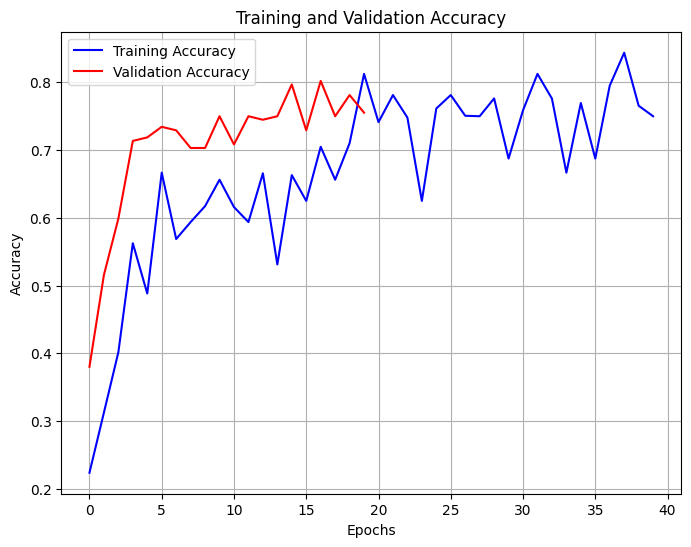

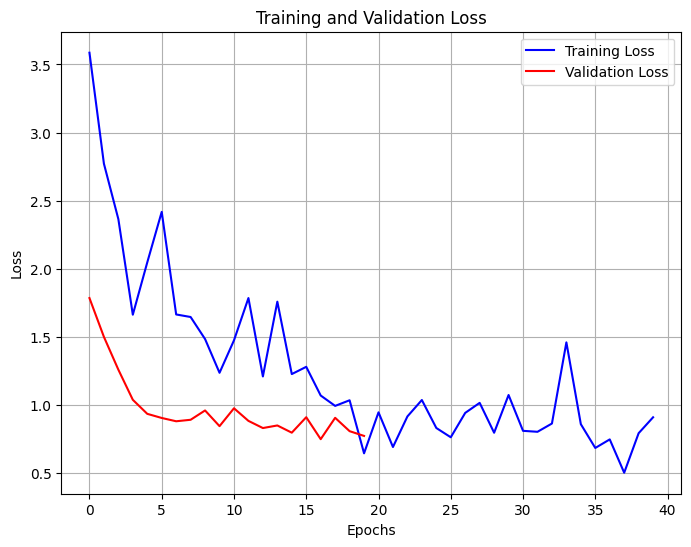

In [55]:
# Ambil nilai akurasi dan loss dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Akurasi Training dan Validasi
plt.figure(figsize=(8, 6))
plt.plot(acc, 'b', label='Training Accuracy')
plt.plot(val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss Training dan Validasi
plt.figure(figsize=(8, 6))
plt.plot(loss, 'b', label='Training Loss')
plt.plot(val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6676 - loss: 1.1267
Test Accuracy: 0.74
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
Classification Report
              precision    recall  f1-score   support

     Biduran       0.65      0.65      0.65        31
       Bisul       0.74      0.64      0.68        22
   Cacar Air       0.63      0.48      0.55        25
     Jerawat       0.93      0.84      0.88        31
       Kurap       0.76      0.96      0.85        27
      Normal       0.93      0.90      0.91        29
        Panu       0.76      0.93      0.83        27

    accuracy                           0.78       192
   macro avg       0.77      0.77      0.76       192
weighted avg       0.78      0.78      0.77       192



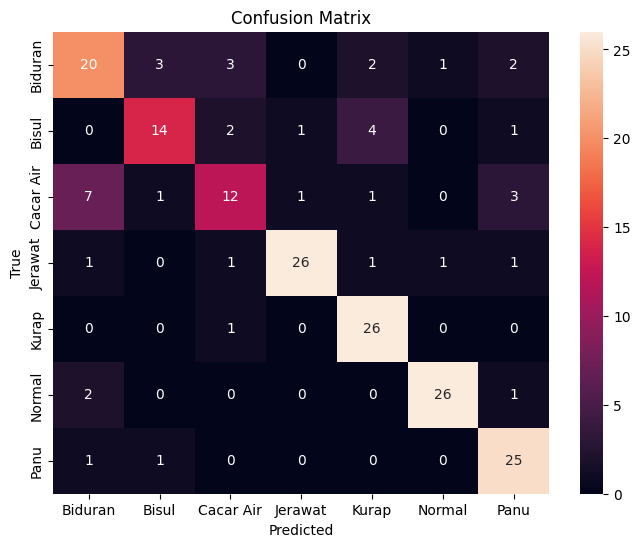

In [56]:
import seaborn as sns
# Evaluasi model pada test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Confusion Matrix
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=validation_generator.class_indices.keys()))

confusion_mtx = confusion_matrix(validation_generator.classes, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#DOWNLOAD MODEL

In [57]:
print(tf.__version__)

2.17.1


In [58]:
model.save('daisy_new.h5')

In [59]:
# Load model dari file .keras
model = tf.keras.models.load_model('daisy_new.h5')

# Konversi ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model dalam format .tflite
with open('daisy_new.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpgdwfoflv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  138255196246912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138255196256240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138255196291312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138255196253952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138255196252016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138255196294480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138255196291488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138255196292896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138255196298352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138255196298000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1382551962976